In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.linalg import solve
from numpy.random import default_rng

seed = 2138746934
rng = default_rng(seed)

plt.rcParams['figure.dpi'] = 150

Following the first example in Bishop, let's create some data by sampling a sine wave and adding some Gaussian-distributed "errors" to our "measurements":

In [2]:
N = 10
x = np.sort(rng.uniform(size=10))
y = np.sin(2*np.pi*x) + rng.standard_normal(size=10) * 0.2

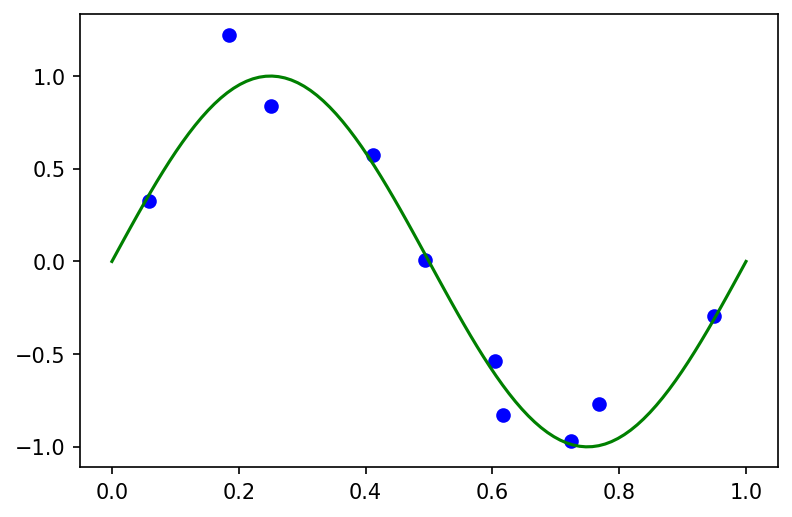

In [3]:
fig, ax = plt.subplots()
ax.plot(x,y, 'bo')
xx= np.linspace(0,1,100)
ax.plot(xx, np.sin(2*np.pi*xx),'g')

We now try to model the data we have just collected. Much of the time in scientific applications we have a physical model in mind (say, the expansion rate of the Universe in a FRW model) and that model has a set of parameters
(say, the Hubble constant and the fractions of matter and dark energy in the universe, all as measured today).

Of course, if you give model-builders enough time, they will come up with models which have an ever-increasing number of parameters (say, not just the amount of dark energy, but the way it evolves with time). Given a certain set of data, how do we choose just how complicated a model to test?

We can try to determine these parameters by "fitting" the model -- varying the parameters until some figure of merit describing the difference between the model and the data is at an extremum. At each data point we
have a difference between the model "prediction" and the data $\varepsilon_i = y_i - f(x_i)$.

One common figure of merit (also known as an "error function", not to be confused with $\mathrm{erf}(x)$!!) is the
sum of the squares of the deviation between the data and the model
$$ E(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^N\left[ f(x_i, \mathbf{w}) - y_i\right]^2 $$
where our model $f$ predicts a value $\hat{y}_i = f(x_i, \mathbf{w})$ from a value $x_i$ depending upon some set of parameters $\mathbf{w}$.

As long as we have no reason to count some values of the data more strongly than others, this seems like a perfectly good function, though perhaps the absolute value of the difference $|y_i - f(x_i, \mathbf{w})|$ would do just as well, or even some other function.

We'll use the sum-of-squares for now...

For our exercise, let our model $f$ be a polynomial of some order $M$ so that the parameters $\mathbf{w}$ are
the polynomial coefficients. At each of the data points $x_i$ our model takes on the values
$$ y_i  = w_0 + w_1 x_i + w_2 x_i^2 + \cdots + w_M x_i^M $$
For the whole set of $N$ data points, we can write this as
$$ \mathbf{y} = \mathbf{X} \mathbf{w} $$
where the $N\times (M+1)$ matrix $\mathbf{X}$ is
$$ \mathbf{X} = \begin{bmatrix} 1 & x_1 & x_1^2 & x_1^3 & \cdots & x_1^M\\
1 & x_2 & x_2^2 & x_2^3 & \cdots &x_2^M \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_N & x_N^2 & x_N^3 & \cdots & x_N^M \end{bmatrix} $$

Our model function is linear in the polynomial coefficients so that our error function $E(\mathbf{w})$ is quadratic in the coefficients. Minimizing this w/r to the coefficients $w_i$ gives us a linear system in the polynomial coefficients. Taking the derivative of $E$ w/r to $w_k$ and setting it to zero, we have
$$ \frac{\partial E}{\partial w_k} = \sum_{j=0}^M \left(\sum_{i=1}^N w_j x_i^j - y_i\right) x_j^k = 0$$

which can be written in the form
$$ (\mathbf{X}^T\mathbf{X}) \mathbf{w} =  \mathbf{X}^T \mathbf{y} $$

The quantity $(\mathbf{X}^T\mathbf{X})$ is thus an $(M+1)\times (M+1)$ matrix. If $N>M$ (more data points than polynomial terms) the matrix is invertible, and the expression for $\mathbf{w}$ is the unique solution which minimizes the error function above. The solution is then
$$ \mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $$

Note that this procedure is rather more general than the polynomial-fitting example just given; it works with any model linear in the parameters. If we write our model function as
$$ f(x,\mathbf{w}) = \sum_{j=0}^M w_j f_j(x) $$
the matrix $\mathbf{X}$ becomes
$$ \mathbf{X} = \begin{bmatrix} f_0(x_1) & f_1(x_1) & f_2(x_1) & f_3(x_1) & \cdots & f_M(x_1) \\
f_0(x_2) & f_1(x_2) & f_2(x_2) & f_3(x_2) & \cdots &f_M(x_2) \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
f_0(x_N) & f_1(x_N) & f_2(x_N) & f_3(x_N) & \cdots & f_M(x_N) \end{bmatrix} $$
and the rest follows as before.

One can thus imagine fitting Fourier coefficients with, *e.g.* $f_i(x) = \sin(2\pi x/i)$.

In Python, we can write the polynomial-fitting case as

In [4]:
# least-squares fit of an M-th order polynomial to data {x_i, y_i}
# returns polynomial coefficients w_0, w_1, w_2, ..., w_M in order of increasing monomial order
def polyfit(M, x, y):
    idx = np.arange(0,M+1)
    X = np.power(x,idx[:,np.newaxis]).T # form X array
    w = solve(X.T@X, X.T@y)
    return w

In [5]:
# evaluate polynomial given by coefficients {w_j} at the points {x_i}
def polynomial(w, x):
    Mp1 = len(w)           # number of coefficients is 1 + polynomial order
    idx = np.arange(0,Mp1)
    return w @ np.power(x, idx[:,np.newaxis])

Let's divide our error function by the number of points, and take the square root so it has the same units as the
$y_i$; the error function becomes

In [6]:
def RMSerror(w, x, y):
    return np.sqrt(2 * np.sum( (polynomial(w,x)-y)**2 )/len(x))

As expected, the higher the order of the polynomial model function, the smaller the error function becomes:

In [7]:
for M in range(0,N):
    w = polyfit(M, x, y)
    e = RMSerror(w,x,y)
    print(f"order M: {M}  error: {e}")

order M: 0  error: 1.020454989839668
order M: 1  error: 0.6431082655065444
order M: 2  error: 0.630239468984812
order M: 3  error: 0.19978494224167534
order M: 4  error: 0.18099384000950045
order M: 5  error: 0.17320303324156044
order M: 6  error: 0.09679035782831232
order M: 7  error: 0.08682450746151567
order M: 8  error: 0.07173093105322192
order M: 9  error: 0.005521475312832419


<ipython-input-4-de2426e99f31>:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.41523e-18): result may not be accurate.
  w = solve(X.T@X, X.T@y)


The higher the order, the more "knobs" we have to turn to customize the model to the data. Once we get to $M=N$,
we can arrange that the polynomial model goes precisely through *all* of the points.

The question Bishop raises, of course, is: "is the fit to the underlying function really better as $M$ increases?"

<ipython-input-4-de2426e99f31>:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.41523e-18): result may not be accurate.
  w = solve(X.T@X, X.T@y)


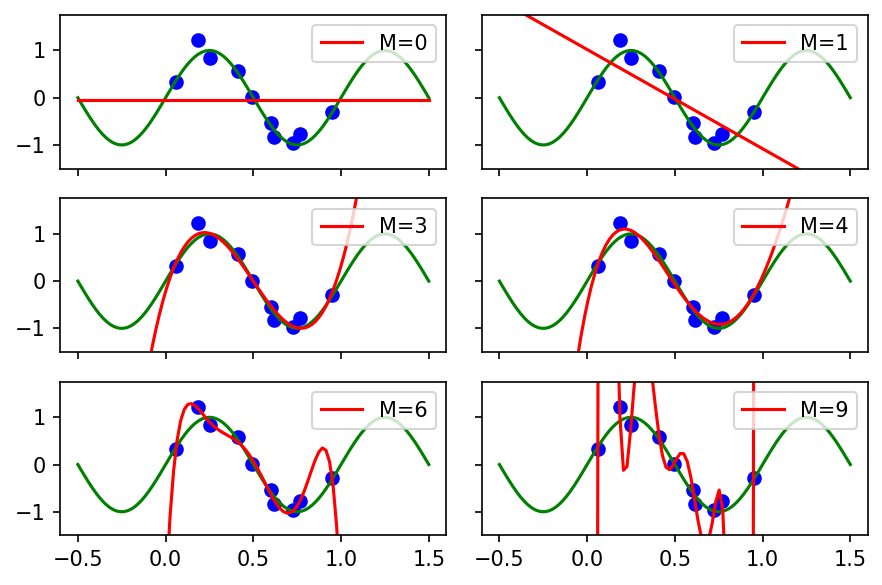

In [8]:
xx= np.linspace(-0.5,1.5,100)

fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
w = polyfit(0, x, y)
ax[0,0].plot(x,y, 'bo')
ax[0,0].plot(xx, np.sin(2*np.pi*xx),'g')
ax[0,0].plot(xx, polynomial(w,xx),'r', label='M=0')
ax[0,0].set_ylim(-1.5,1.75);
ax[0,0].legend(loc=1)

w = polyfit(1, x, y)
ax[0,1].plot(x,y, 'bo')
ax[0,1].plot(xx, np.sin(2*np.pi*xx),'g')
ax[0,1].plot(xx, polynomial(w,xx),'r', label='M=1')
ax[0,1].set_ylim(-1.5,1.75);
ax[0,1].legend(loc=1)

w = polyfit(3, x, y)
ax[1,0].plot(x,y, 'bo')
ax[1,0].plot(xx, np.sin(2*np.pi*xx),'g')
ax[1,0].plot(xx, polynomial(w,xx),'r', label='M=3')
ax[1,0].set_ylim(-1.5,1.75);
ax[1,0].legend(loc=1)

w = polyfit(4, x, y)
ax[1,1].plot(x,y, 'bo')
ax[1,1].plot(xx, np.sin(2*np.pi*xx),'g')
ax[1,1].plot(xx, polynomial(w,xx),'r', label='M=4')
ax[1,1].set_ylim(-1.5,1.75)
ax[1,1].legend(loc=1)

w = polyfit(6, x, y)
ax[2,0].plot(x,y, 'bo')
ax[2,0].plot(xx, np.sin(2*np.pi*xx),'g')
ax[2,0].plot(xx, polynomial(w,xx),'r', label='M=6')
ax[2,0].set_ylim(-1.5,1.75);
ax[2,0].legend(loc=1)

w = polyfit(9, x, y)
ax[2,1].plot(x,y, 'bo')
ax[2,1].plot(xx, np.sin(2*np.pi*xx),'g')
ax[2,1].plot(xx, polynomial(w,xx),'r', label='M=9')
ax[2,1].set_ylim(-1.5,1.75)
ax[2,1].legend(loc=1)

plt.tight_layout()

Clearly, our polynomial model has little to do with $\sin(2\pi x)$, and resembles it less and less as $M$ increases
past, say, $M=3$.

If we were to obtain another sample of data (what Bishop calls the "test set" as opposed to the "training set" on which we fit our model function), our errors look like

order M: 0  error training: 1.020454989839668   error test: 1.0949079800690915
order M: 1  error training: 0.6431082655065444   error test: 0.9458983170209122
order M: 2  error training: 0.630239468984812   error test: 0.8980241567087325
order M: 3  error training: 0.19978494224167534   error test: 1.1789183269270798
order M: 4  error training: 0.18099384000950045   error test: 1.176834947231862
order M: 5  error training: 0.17320303324156044   error test: 1.1656132595580146
order M: 6  error training: 0.09679035782831232   error test: 1.6951679825117476
order M: 7  error training: 0.08682450746151567   error test: 2.0584910518669695
order M: 8  error training: 0.07173093105322192   error test: 3.815200929500872
order M: 9  error training: 0.005521475312832419   error test: 78.39647484417966


<ipython-input-4-de2426e99f31>:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.41523e-18): result may not be accurate.
  w = solve(X.T@X, X.T@y)


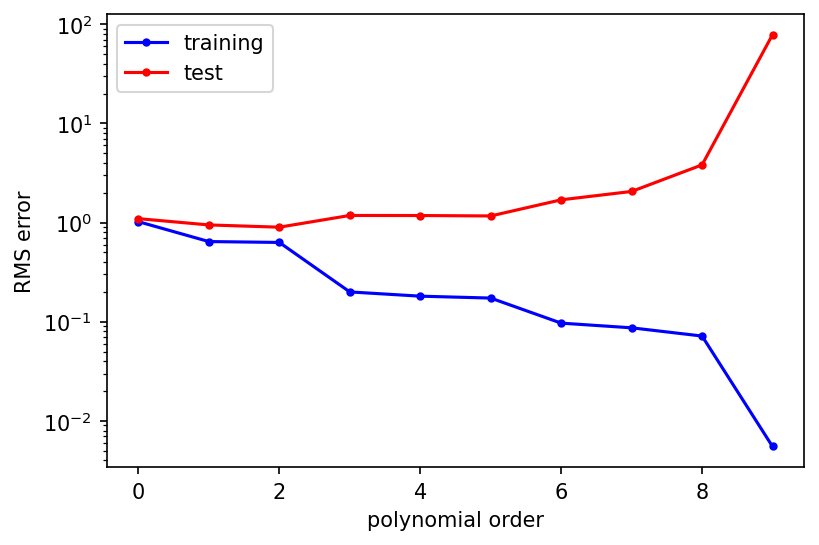

In [9]:
xtest = np.sort(rng.uniform(size=10))
ytest = np.sin(2*np.pi*x) + rng.standard_normal(size=10) * 0.2

e = np.zeros(N)
et = np.zeros(N)
order = np.zeros(N)
for M in range(0,N):
    w = polyfit(M, x, y)
    e[M] = RMSerror(w, x, y)
    et[M] = RMSerror(w,xtest,ytest)
    print(f"order M: {M}  error training: {e[M]}   error test: {et[M]}")
    order[M] = M
    
fig, ax = plt.subplots()
ax.semilogy(order, e, 'b.-', label='training')
ax.semilogy(order, et, 'r.-', label='test')
ax.set_xlabel("polynomial order")
ax.set_ylabel("RMS error")
ax.legend();

Clearly, the RMS error is a bad metric for judging the "goodness of fit" in this context. A low error on the training set is obviously not very indicative of low error when more data is obtained (the "test data").

Perhaps just as bad or even worse, the 9th order polynomial which does pass, snakelike, directly through all of the points, is very likely not what we had in mind as the underlying process (even if we had no "oracle" to tell us
the right answer!).

When we decided to try to represent the data with an underlying model, we may have had some reason to prefer a polynomial function. It may even have been a good reason. Indeed, the third-order result is pretty good, but so
are the fourth- and fifth-order functions.

To bring everything out into the open, we likely did have in mind something more about the model function than simply that it be a polynomial. We probably wanted the function to be as "simple" as possible; in this context,
probably that it be the lowest-order polynomial which gives "reasonable" results.

How do we insert this desire for "reasonableness" and "simplicity" into our mathematics?

One way comes from looking at the polynomial coefficients as the order of the polynomial increases

In [10]:
for M in range(N):
    w = polyfit(M, x, y)
    
    print(f"{M:2d}: ",end="" )
    for i in range(M+1):
        print(f"{w[i]: .2e} ", end="")
    print()

 0: -4.25e-02 
 1:  1.02e+00 -2.10e+00 
 2:  1.24e+00 -3.36e+00  1.29e+00 
 3: -2.19e-01  1.24e+01 -3.61e+01  2.42e+01 
 4: -4.91e-01  1.72e+01 -5.65e+01  5.55e+01 -1.56e+01 
 5: -1.65e-01  9.29e+00 -4.81e+00 -7.97e+01  1.37e+02 -6.14e+01 
 6: -2.87e+00  8.48e+01 -6.38e+02  2.25e+03 -4.07e+03  3.61e+03 -1.24e+03 
 7: -4.56e+00  1.37e+02 -1.18e+03  4.91e+03 -1.10e+04  1.36e+04 -8.60e+03  2.19e+03 
 8: -1.14e+01  3.70e+02 -3.95e+03  2.13e+04 -6.55e+04  1.20e+05 -1.30e+05  7.65e+04 -1.90e+04 
 9: -2.94e+02  1.06e+04 -1.39e+05  9.43e+05 -3.75e+06  9.22e+06 -1.42e+07  1.34e+07 -7.02e+06  1.57e+06 


<ipython-input-4-de2426e99f31>:6: LinAlgWarning: Ill-conditioned matrix (rcond=1.41523e-18): result may not be accurate.
  w = solve(X.T@X, X.T@y)


As the order $M$ increases, the coefficients become increasingly large in magnitude and alternate in sign.

What if we included a constraint which biassed our result to polynomials with smaller (in absolute value) coefficients? We could add this to our sum-of-squares error function as
$$ E(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^N\left[ f(x_i, \mathbf{w}) - t_i\right]^2 + \frac{\lambda}{2}|\mathbf{w}|^2 $$
where the constant $\lambda$ quantifies our belief that the polynomial fit should have small coefficients (and
the norm is the 2-norm $|\mathbf{w}| = \sqrt{\sum w_i^2}$).

By choosing a value of $\lambda$ we are adding additional information to the process of fitting the model. This process is known as *regularization* (in this case it is known as Tikhonov regularization). We're now requiring
that the model fitting procedure minimze the effect of higher-order polynomial terms.

We can easily add this to our polynomial-fitting algorithm:
$$ (\mathbf{X}^T\mathbf{X} + \lambda N \mathbf{I}) \mathbf{w} =  \mathbf{X}^T \mathbf{y} $$
and to our Python function:

In [11]:
# Tikhonov-regularized least-squares fit of an M-th order polynomial to data (x_i, y_i)
# returns polynomial coefficients w_0, w_1, w_2, ..., w_M
def polyfit(M, lam, x, y):
    idx = np.arange(0,M+1)
    X = np.power(x,idx[:,np.newaxis]).T # form X array
    w = solve(X.T@X + lam*N*np.eye(M+1), X.T@y)
    return w

Let's try it out with $\lambda=1$:

In [12]:
for M in range(N):
    w = polyfit(M, 1.0, x, y)
    
    print(f"{M:2d}: ",end="" )
    for i in range(M+1):
        print(f"{w[i]: .2e} ", end="")
    print()

 0: -2.13e-02 
 1:  1.26e-02 -1.34e-01 
 2:  2.76e-02 -1.19e-01 -1.15e-01 
 3:  3.45e-02 -1.11e-01 -1.08e-01 -8.41e-02 
 4:  3.77e-02 -1.07e-01 -1.04e-01 -8.04e-02 -5.93e-02 
 5:  3.94e-02 -1.05e-01 -1.01e-01 -7.83e-02 -5.73e-02 -4.13e-02 
 6:  4.02e-02 -1.04e-01 -1.00e-01 -7.70e-02 -5.60e-02 -4.01e-02 -2.86e-02 
 7:  4.07e-02 -1.03e-01 -9.94e-02 -7.62e-02 -5.53e-02 -3.94e-02 -2.79e-02 -1.97e-02 
 8:  4.09e-02 -1.03e-01 -9.89e-02 -7.57e-02 -5.48e-02 -3.90e-02 -2.75e-02 -1.93e-02 -1.34e-02 
 9:  4.11e-02 -1.03e-01 -9.87e-02 -7.55e-02 -5.45e-02 -3.87e-02 -2.72e-02 -1.90e-02 -1.32e-02 -9.06e-03 


We'll try $M=9$ with a variety of $\lambda$'s:

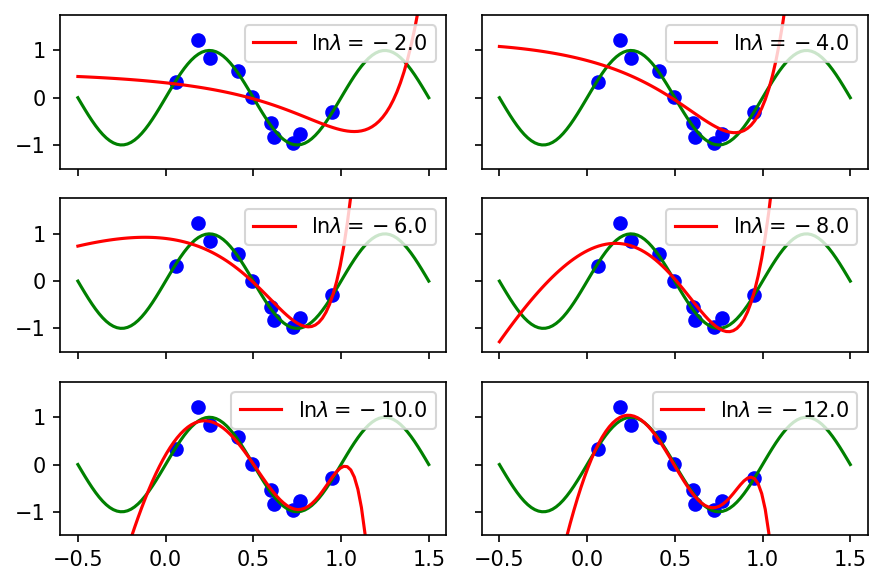

In [13]:
xx= np.linspace(-0.5,1.5,100)

fac = np.exp(-2)

lam = fac

fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
w = polyfit(9, lam, x, y)
ax[0,0].plot(x,y, 'bo')
ax[0,0].plot(xx, np.sin(2*np.pi*xx),'g')
ax[0,0].plot(xx, polynomial(w,xx),'r', label=f'$\ln\lambda={np.log(lam):0.1f}$')
ax[0,0].set_ylim(-1.5,1.75);
ax[0,0].legend(loc=1)

lam *= fac

w = polyfit(9, lam, x, y)
ax[0,1].plot(x,y, 'bo')
ax[0,1].plot(xx, np.sin(2*np.pi*xx),'g')
ax[0,1].plot(xx, polynomial(w,xx),'r', label=f'$\ln\lambda={np.log(lam):0.1f}$')
ax[0,1].set_ylim(-1.5,1.75);
ax[0,1].legend(loc=1)

lam *= fac

w = polyfit(9, lam, x, y)
ax[1,0].plot(x,y, 'bo')
ax[1,0].plot(xx, np.sin(2*np.pi*xx),'g')
ax[1,0].plot(xx, polynomial(w,xx),'r', label=f'$\ln\lambda={np.log(lam):0.1f}$')
ax[1,0].set_ylim(-1.5,1.75);
ax[1,0].legend(loc=1)

lam *= fac

w = polyfit(9, lam, x, y)
ax[1,1].plot(x,y, 'bo')
ax[1,1].plot(xx, np.sin(2*np.pi*xx),'g')
ax[1,1].plot(xx, polynomial(w,xx),'r', label=f'$\ln\lambda={np.log(lam):0.1f}$')
ax[1,1].set_ylim(-1.5,1.75)
ax[1,1].legend(loc=1)

lam *= fac

w = polyfit(9, lam, x, y)
ax[2,0].plot(x,y, 'bo')
ax[2,0].plot(xx, np.sin(2*np.pi*xx),'g')
ax[2,0].plot(xx, polynomial(w,xx),'r', label=f'$\ln\lambda={np.log(lam):0.1f}$')
ax[2,0].set_ylim(-1.5,1.75);
ax[2,0].legend(loc=1)

lam *= fac

w = polyfit(9, lam, x, y)
ax[2,1].plot(x,y, 'bo')
ax[2,1].plot(xx, np.sin(2*np.pi*xx),'g')
ax[2,1].plot(xx, polynomial(w,xx),'r', label=f'$\ln\lambda={np.log(lam):0.1f}$')
ax[2,1].set_ylim(-1.5,1.75)
ax[2,1].legend(loc=1)

plt.tight_layout()

The fit with $\log\lambda=-12$ seems pretty good; let's examine the coefficients

In [14]:
M = 9
w = polyfit(M, np.exp(-12), x, y)
    
print(f"{M:2d}: ",end="" )
for i in range(M+1):
    print(f"{w[i]: .2e} ", end="")
print()

 9: -1.12e-01  9.85e+00 -2.03e+01 -4.98e+00  6.71e+00  1.04e+01  8.40e+00  3.20e+00 -3.44e+00 -1.03e+01 


Let's see how we do against the test set of data; better, but still not very promising.

order M: 0  error training: 1.0204549898397348   error test: 1.094908009742306
order M: 1  error training: 0.6431082712009897   error test: 0.9458719148475928
order M: 2  error training: 0.630239759454233   error test: 0.8981392051405624
order M: 3  error training: 0.20397012546028193   error test: 1.1372597536809326
order M: 4  error training: 0.21815423595061742   error test: 1.155759225845981
order M: 5  error training: 0.20283073654637565   error test: 1.1488432857408863
order M: 6  error training: 0.18673370603313272   error test: 1.1483581492033998
order M: 7  error training: 0.1765984236181569   error test: 1.1533766152723595
order M: 8  error training: 0.1705182065512229   error test: 1.1606293246785353
order M: 9  error training: 0.16698407865580947   error test: 1.168422075641567


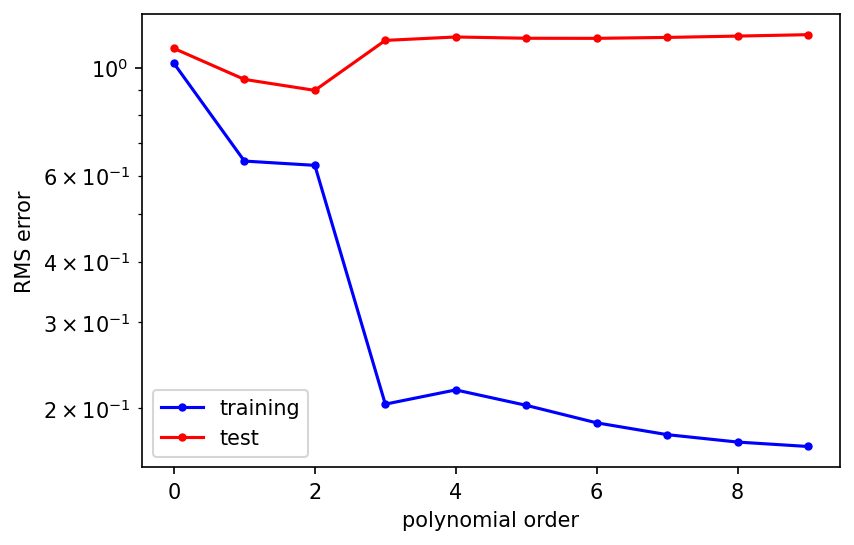

In [15]:
e = np.zeros(N)
et = np.zeros(N)
order = np.zeros(N)
for M in range(0,N):
    w = polyfit(M, np.exp(-12), x, y)
    e[M] = RMSerror(w, x, y)
    et[M] = RMSerror(w,xtest,ytest)
    print(f"order M: {M}  error training: {e[M]}   error test: {et[M]}")
    order[M] = M
    
fig, ax = plt.subplots()
ax.semilogy(order, e, 'b.-', label='training')
ax.semilogy(order, et, 'r.-', label='test')
ax.set_xlabel("polynomial order")
ax.set_ylabel("RMS error")
ax.legend();

How do we optimally choose $\lambda$ and how do we put errors on our model fit, on the determined $w_i$'s? To answer these questions, we need to begin our study of probability and statistics.

***

A *random variable* takes on values from a random process. For example, the uniform random numbers we have been using in Monte Carlo simulations are a random variable, the probability density of which is
$$ p(X=x)dx = \left\{ \begin{array}{ll} 1, & x\in[0,1)\\0, & \textrm{else} \end{array}\right. $$
Here, $X$ is the random variable, and $x$ is a particular realization. In the following, we will simply write $P(X)$ for $P(X=x)$ where the meaning is unambiguous.

A random variable can be *discrete*, taking on one of a finite set of values as in the roll of a die or flip of a coin, or *continuous*, for example taking on a real number as in the Wiener process we encountered last week.

The precise definition of these ideas is the subject of *measure theory*, but one can go a long way with the somewhat imprecise notion of probabilities as the result of a sampling procedure. Imagine there are three blue balls and six red balls in a box. Remove a ball from the box without looking, note its color, and then replace it in the box. If we were to
repeat this process an infinite number of times, the fraction of blue balls withdrawn would
converge to $1/3$ and the fraction of red balls would converge to $2/3$. We would thus say that the discrete random variable *Color* would take on the value blue with $P(Color=blue) = 1/3$ and $P(Color=red) = 2/3$.

The introductory chapter in Bishop gives some more elaborate examples of how to calculate with probabilities which we will not repeat here except to remind ourselves of some definitions:

Imagine we draw a blue ball, and then ask: what is the probability of drawing another blue ball? The *prior* probability of drawing a blue ball is 1/3. The *posterior*, or *conditional* probability of drawing a second blue ball, written as $P(blue|First=blue)$ is
then $2/8=1/4$.

The *joint* probability that the the first two balls are blue is the probaility that the first is blue, $P(First=blue)$, times the conditional probability that the second is blue given that the first was blue, $P(blue|First=blue)$, or $P(First=blue, Second=blue) = P(blue) P(blue|First=blue)$, or $1/3\times 1/4 = 1/12$.

Generalizing from this, we have the *product rule* of probabilities
$$ P(X,Y) = P(Y|X) P(X) $$
A similiar counting argument gives us the *sum rule* of probabilties
$$ P(X) = \sum_{\textrm{all } Y} P(X,Y) $$
and the symmetry property that
$$ P(X,Y) = P(Y,X) $$

Using these ideas, we can derive Bayes Theorem (really due to Laplace!). Start with the product rule
$$ P(X,Y) = P(Y|X) P(X) $$
By symmetry, we can write 
$$ P(Y,X) = P(X|Y)P(Y) = P(Y|X)P(X) = P(X,Y) $$
and solving for $P(Y|X)$ we have Bayes theorem:
$$ P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)} $$

Using the sum and product rules, write the denomiator as
$$ P(X) = \sum_Z P(X|Z)P(Z) $$
and Bayes theorem becomes
$$ P(Y|X) = \frac{P(X|Y)P(Y)}{\sum_Z P(X|Z)P(Z)} $$
The denominator thus ensure the proper normalization of $P(Y|X)$ as a probability.


For continuous distributions, we have the sum rule on the probability densities
$$ p(x) = \int p(x,y) dy $$
with the product rule
$$ p(x,y) = p(y|x) p(x) $$
and Bayes' theorem remains unchanged, with the normalization
$$ p(x) = \int p(x|y)p(y) dy $$

***

The weighted average of some function $f(x)$ over a probability distribution $p(x)$ is
the *expectation*
$$ \mathbb{E}(f) = \sum_x p(x) f(x) $$
or
$$ \mathbb{E}(f) = \int p(x) f(x) dx $$
Since probabilities must sum to one, we have
$$ \mathbb{E}(f) \approx \frac{1}{N} \sum_{i=1}^N f(x_i) $$

If we have a joint distribution $p(x,y)$ and wish to average $f(x)$ over $x$, we
have
$$ \mathbb{E}_x[f(x,y)] = \int p(x,y) f(x,y) dx $$
and similarly, if we average over a conditional distribution, we have the conditional
expectation
$$ \mathbb{E}_x[f|y] = \int p(x|y) f(x) dx $$

The variance of $f(x)$ is 
\begin{align} \mathrm{var}[f] &= \mathbb{E}[ (f(x)- \mathbb{E}[f(x)])^2 ] \\
&= \mathbb{E}[f(x)^2] - \mathbb{E}[f(x)]^2 \end{align}

Finally, the covariance between two variables is
\begin{align}
\textrm{cov}[x,y] &= \mathbb{E}_{x,y}\left[ (x-\mathbb{E}(x))(y-\mathbb{E}(y)) \right]\\
&= \mathbb{E}_{x,y}[x,y] - \mathbb{E}[x]\mathbb{E}[y]
\end{align}

***

How does all of this help us in our data modelling problem?

Imagine making a measurement of some quantity. We typically attempt to assign an uncertainty to our measurement, perhaps by measuring a known quantity (calibration).
We repeat this process many times and find there is an asymmetric uncertainty in our
result and a bias:

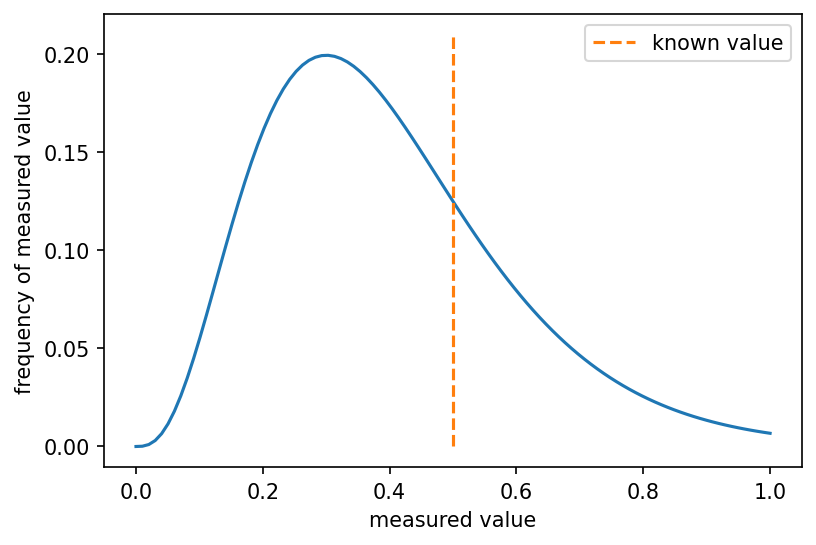

In [26]:
fig, ax = plt.subplots()
xx = np.linspace(0,1,100)
ax.plot(xx, xx**3*np.exp(-(xx-0.5) * 10))
ax.plot([.5,.5],[0,.21],'--', label='known value')
ax.set_xlabel('measured value')
ax.set_ylabel('frequency of measured value')
ax.legend();

Much of the time, we make *one* measurement and assign an uncertainty either by performing this kind of calibration or by making a physical model of the measurement.

Dealing with this can become tricky if the uncertainties are asymetric and/or the frequency distribution of measurements doesn't peak at the true value (*i.e.* there is a measurement bias).

As a simple (and typical) example, imagine you are doing a counting experiment -- for example counting photons in an image. How do we assign an error to our measurement?

Counting experiments follow Poisson statistics. If the true number of counts is $M$, the probability that you actually measure $N$ is
$$ P(N|M) = \frac{M^N e^{-M}}{N!} $$
The variance of this distribution is $\sigma^2 = M$, not $\sigma^2 = N$, but of course we don't *know* $M$.

The traditional way of thinking about assigning errors is to try to calculate
$$ P(\mathrm{data}|\mathrm{model}) $$
and not 
$$ P(\mathrm{model}|\mathrm{data})$$

These are not equivalent statements! For example
$$ P(\mathrm{astronomer}| \mathrm{human}) $$
is manifestly not the same as 
$$ P(\mathrm{human} | \mathrm{astronomer} ) $$
whether or not you allow for non-human astronomers!

By assigning error bars to our model instead of to our data, we can make some progress dealing with our data modeling problem.

Recall that we had some preconceived (prior) notion of the smoothness properties of our polynomial model for the fake data we started with above. We can think of this as a prior notion of the probability of a certain set of parameters $p(\mathbf{w})$.

Once we have taken the data (call them $D$), these data further inform us about the values of the paramaters, so we can use Bayes theorem to write
$$ p(\mathbf{w}|D) = \frac{p(D|\mathbf{w})p(\mathbf{w})}{p(D)} $$

Here we express the uncertainty in the parameters $\mathbf{w}$ after we have obtained the data $D$. The quantity $p(D|\mathbf{w})$ is called the *likelihood* function, expressing how probable it would be to observe $D$ *if* a given set of parameters were correct. The denominator is the normalization
$$ p(D) = \int p(D|\mathbf{w}) p(\mathbf{w}) d\mathbf{w}$$

In other words, the posterior probability of $\mathbf{w}$ is proportional to the likelihood of the $D$ given those same $\mathbf{w}$ times the prior probability we assigned to those parameter values:
$$ \mathrm{posterior}(\mathbf{w}|D) = C \times \mathrm{likelihood}(D|\mathbf{w}) \times \mathrm{prior}(\mathbf{w}) $$ 

In the "frequentist" viewpoint, we have a fixed set of parameters $\mathbf{w}$ determined by some process such as the one we employed above, using a particular set of data.
The uncertainty in these parameters is then obtained by looking at a variety of datasets $D$ (our "test" data above).

In the Bayesian viewpoint, we have only one set of data, the $D$ we measured, and we express the uncertainly in the model by deriving a probability distribution over $\mathbf{w}$.

Once fundamental difference between these two viewpoints is the presence of the prior $p(\mathbf{w})$. On the one hand, this gives us a nice, formal way to combine the results of experiments. The prior in analysing the second experiment is the posterior distribution
from the first.

On the other hand, what do we do about specifying the prior of the first experiment? Let's defer consideration of this important question while trying to recast our curve-fitting example in terms of probability distributions.

***

Let's assume for the moment that the values of our data points have uncertainties which are
Gaussian distributed, so that
$$ p(y|x, \mathbf{w}, \sigma) = \mathcal{N}(y|y(x, \mathbf{w}), \sigma) $$

The likelihood of the data given the model is then the product of the likelihoods of each data point
$$ \mathcal{L} = \Pi_{i=1}^N \mathcal{N}(y-I|y(x_i, \mathbf{w}), \sigma) $$
Numerically, a better-conditioned expression would be the log of the liklihood
$$ \log\mathcal{L} = -\frac{N}{2}\ln\sigma - \frac{N}{2}\ln(2\pi) - \sum_{i=1}^N \frac{\left(y(x_i,\mathbf{w})-y_i\right)^2}{\sigma_i^2} $$
If we minimize the log likelihood, the first two terms are just a constant which doesn't affect the result, and so we see that this is just our least-squares error function.

Minimizing w/r to $\sigma$, we have 
$$ \sigma^2 = \frac{1}{N} \sum_{i=1}^N \left(y(x_i,\mathbf{w}_{ML}) - y_i\right)^2 $$

We now have the values of $\mathbf{w}$ and $\sigma$ which maximize the likelihood. What should our prior be? Bishop chooses to use
$$ p(\mathbf{w}|\alpha) = \mathcal{N}(\mathbf{w}|\mathbf{0},\alpha^{-1},\mathbf{I}) = 
\left(\frac{\alpha}{2\pi}\right)^{(M+1)/2} \exp\left\{-\frac{\alpha}{2} \mathbf{w}^T\mathbf{w}\right\} $$
where $\alpha$ is known as a *hyperparameter*, controlling the probability distribution of parameters.

Using Bayes' theorem, we can now write the posterior distribution as
$$ p(\mathbf{w}|D, \alpha, \sigma) \propto p(D|\mathbf{w},\sigma) p(\mathbf{w}|\alpha) $$
and determine the most probable values for $\mathbf{w}$ by maximizing the posterior distribtion, given by the minimum of 
$$ \frac{1}{2\sigma^2} \sum_{i=1}^N\left( y(x_i,\mathbf{w})-y_i)\right)^2 + \frac{\alpha}{2} \mathbf{w}^T\mathbf{w} $$
which is, again, the same result as before, with $\lambda = \alpha\sigma^2$.

To obtain errorbars on our model, we still need to compute the normalization 
$$ p(D) = \int p(D|\mathbf{w}) p(w|D) d\mathbf{w} $$
Because we have chosen Gaussian distribtions throughout, we can do this integral analytically, with the result that the distribution of model predictions at a point is
itself Gaussian
$$ p(y|x,D) = \mathcal{N}(y|\mu(x), \sigma(x)) $$
with mean
$$ \mu(x) = \frac{1}{\sigma^2} \phi(x)^T \mathbf{S}\sum_{i=1}^N\phi(x_i) y_i $$
and variance
$$ \sigma^2(x) = \sigma^2 + \phi(x)^T\mathbf{S}\phi(x) $$
where
$$ \mathbf{S} = \left[ \alpha\mathbf{I} + \mathbf{X}^T \mathbf{X}\right]^{-1} $$
and the $\phi$ are the row-vectors of $\mathbf{X}$, $\phi(x) = \left\{1, x, x^2, \dots, x^M\right\}$.

We now have quantified the uncertainty in the determination of the $\mathbf{w}$ for the given value of $\alpha$ used in our prior on $\mathbf{w}$ and can compare the model prediction, complete with error bars, to the observed distribution of the data $D$.
